**Performing a training (80%) and testing split (20%) of the images in the dataset**

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import cv2
import glob
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/FINAL PROJECT/COSC 680_FINAL PROJECT/Dermo_GroundTruth.csv", header=None)
base_dir = "/content/drive/MyDrive/FINAL PROJECT/COSC 680_FINAL PROJECT/dermo_images/"

y = []
X = []

for i in range(len(df)): 
	image = cv2.imread(base_dir + df[0][i] + '.jpg')
	image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
	X.append(image)
	Y = df[1][i]
	y.append(Y)
	
X = np.array(X)
y = np.array(y)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

enc = LabelEncoder()

y_tranformed = enc.fit_transform(y)

#y = to_categorical(y_tranformed)
(X_train, X_test, y_train, y_test) = train_test_split(X, y_tranformed, train_size=0.8)

In [ ]:
#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

**Load the MobileNetV2 architecture (with pre-trained ImageNet weights) from disk, leaving off the fully connected layers**

In [ ]:
tf.keras.applications.MobileNetV2(
    input_shape=None,
    alpha=1.0,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

**Define a new fully connected layer head based on your dataset**

In [ ]:
feature_batch = base_model(X_train)

In [ ]:
import tensorflow as tf

single_feature_normalizer = tf.keras.layers.Normalization(axis=None)
feature = tf.random.normal((314, 1))
single_feature_normalizer.adapt(feature)

single_feature_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    single_feature_normalizer,
    tf.keras.layers.Dense(1)
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(720, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(2)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

**Place the new FC layer head on top of the MobileNetV2 base network.**

In [ ]:
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

**Freeze all of the CONV layers in the body of MobileNetV2**

In [ ]:
base_model.trainable = False

**Train your network in the training set  while applying data augmentation (such as rotation and horizontal flipping), only updating the weights for the head of the network.**

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
X_train.shape

(720, 224, 224, 3)

**Evaluate the  network on your  testing data and print the classification statistics.**

In [ ]:
from zmq.constants import XPUB_MANUAL

initial_epochs = 10

history = model.fit(X_train, y_train, epochs=initial_epochs, validation_data= (X_test, y_test))

Epoch 1/10
23/23 [==============================] - 47s 2s/step - loss: 0.6771 - accuracy: 0.6792 - val_loss: 0.6249 - val_accuracy: 0.7667
Epoch 2/10
23/23 [==============================] - 44s 2s/step - loss: 0.5809 - accuracy: 0.7861 - val_loss: 0.6336 - val_accuracy: 0.7667
Epoch 3/10
23/23 [==============================] - 45s 2s/step - loss: 0.5376 - accuracy: 0.7847 - val_loss: 0.6172 - val_accuracy: 0.7667
Epoch 4/10
23/23 [==============================] - 46s 2s/step - loss: 0.5510 - accuracy: 0.7847 - val_loss: 0.6073 - val_accuracy: 0.7667
Epoch 5/10
23/23 [==============================] - 41s 2s/step - loss: 0.5439 - accuracy: 0.7667 - val_loss: 0.6085 - val_accuracy: 0.7667
Epoch 6/10
23/23 [==============================] - 41s 2s/step - loss: 0.5256 - accuracy: 0.7847 - val_loss: 0.5964 - val_accuracy: 0.7667
Epoch 7/10
23/23 [==============================] - 41s 2s/step - loss: 0.5266 - accuracy: 0.7778 - val_loss: 0.5935 - val_accuracy: 0.7722
Epoch 8/10
23/23 [==

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

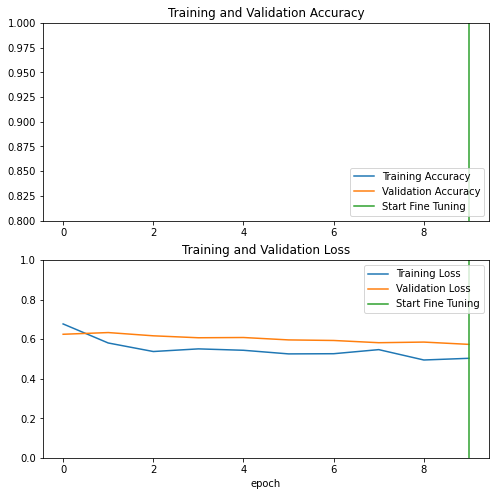

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
accuracy = model.evaluate(X_test)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test accuracy : [0.0, 0.0]


Predictions:
 [1 0 1 ... 0 1 0]
Labels:
 [0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 

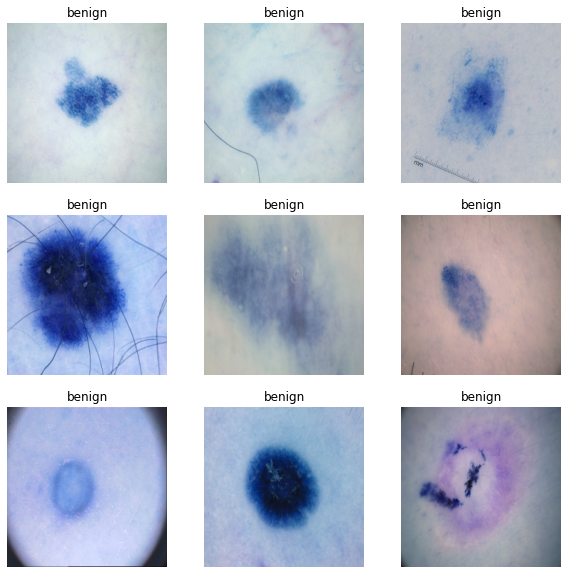

In [ ]:
# Retrieve a batch of images from the test set
label_batch = y_train
predictions = model.predict_on_batch(X_train).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i].astype("uint8"))
  plt.title(y[predictions[i]])
  plt.axis("off")